# Exoplanet Exploration with an ANN

Based on `exoplanet_ANN.py`.

## Imports

In [176]:
import os
import warnings
import math
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
plt.style.use('bmh')

from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

import seaborn as sns
sns.set_theme()
sns.set_context('paper')

from scipy import ndimage

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model
from sklearn.metrics import (recall_score, classification_report, precision_score, confusion_matrix, accuracy_score, 
                            mean_squared_error, mean_absolute_error)
from sklearn.preprocessing import StandardScaler, normalize

from sklearn.decomposition import PCA

from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import SMOTE

from tensorflow import random
random.set_seed(101)

# from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout

## Read data

In [15]:
train_data = pd.read_csv('../exoplanet_exploration_data/exoTrain.csv').fillna(0)
train_data

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,1,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,1,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,1,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,1,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


In [16]:
test_data = pd.read_csv('../exoplanet_exploration_data/exoTest.csv').fillna(0)
test_data

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,...,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,...,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,...,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,...,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,...,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,1,374.46,326.06,319.87,338.23,251.54,209.84,186.35,167.46,135.45,...,-123.55,-166.90,-222.44,-209.71,-180.16,-166.83,-235.66,-213.63,-205.99,-194.07
566,1,-0.36,4.96,6.25,4.20,8.26,-9.53,-10.10,-4.54,-11.55,...,-12.40,-5.99,-17.94,-11.96,-12.11,-13.68,-3.59,-5.32,-10.98,-11.24
567,1,-54.01,-44.13,-41.23,-42.82,-39.47,-24.88,-31.14,-24.71,-13.12,...,-0.73,-1.64,1.58,-4.82,-11.93,-17.14,-4.25,5.47,14.46,18.70
568,1,91.36,85.60,48.81,48.69,70.05,22.30,11.63,37.86,28.27,...,2.44,11.53,-16.42,-17.86,21.10,-10.25,-37.06,-8.43,-6.48,17.60


In [17]:
no_objects = train_data.shape[0] + test_data.shape[0]
no_objects

5657

In [18]:
train_data.columns

Index(['LABEL', 'FLUX.1', 'FLUX.2', 'FLUX.3', 'FLUX.4', 'FLUX.5', 'FLUX.6',
       'FLUX.7', 'FLUX.8', 'FLUX.9',
       ...
       'FLUX.3188', 'FLUX.3189', 'FLUX.3190', 'FLUX.3191', 'FLUX.3192',
       'FLUX.3193', 'FLUX.3194', 'FLUX.3195', 'FLUX.3196', 'FLUX.3197'],
      dtype='object', length=3198)

In [19]:
full_data = pd.concat([train_data, test_data], axis=0)
full_data

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,1,374.46,326.06,319.87,338.23,251.54,209.84,186.35,167.46,135.45,...,-123.55,-166.90,-222.44,-209.71,-180.16,-166.83,-235.66,-213.63,-205.99,-194.07
566,1,-0.36,4.96,6.25,4.20,8.26,-9.53,-10.10,-4.54,-11.55,...,-12.40,-5.99,-17.94,-11.96,-12.11,-13.68,-3.59,-5.32,-10.98,-11.24
567,1,-54.01,-44.13,-41.23,-42.82,-39.47,-24.88,-31.14,-24.71,-13.12,...,-0.73,-1.64,1.58,-4.82,-11.93,-17.14,-4.25,5.47,14.46,18.70
568,1,91.36,85.60,48.81,48.69,70.05,22.30,11.63,37.86,28.27,...,2.44,11.53,-16.42,-17.86,21.10,-10.25,-37.06,-8.43,-6.48,17.60


In [20]:
categ = {2: 1, 1: 0}  # maps labels from 2&1 to 1&0
train_data.LABEL = [categ[item] for item in train_data.LABEL]
test_data.LABEL = [categ[item] for item in test_data.LABEL]
full_data.LABEL = [categ[item] for item in full_data.LABEL]

## Reduce Memory

In [21]:
def reduce_memory(df):
    '''
    Iterates through all the columns of a df and modifies the data type to reduce memory usage.
    '''
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [22]:
red_test_data = reduce_memory(test_data)

Memory usage of dataframe is 13.91 MB
Memory usage after optimization is: 6.25 MB
Decreased by 55.1%


In [23]:
red_train_data = reduce_memory(train_data)

Memory usage of dataframe is 124.12 MB
Memory usage after optimization is: 62.04 MB
Decreased by 50.0%


In [24]:
red_full_data = reduce_memory(full_data)

Memory usage of dataframe is 138.07 MB
Memory usage after optimization is: 69.04 MB
Decreased by 50.0%


## Dataset is imbalanced

In [25]:
Counter(train_data['LABEL'])

Counter({0: 5050, 1: 37})

Text(0.5, 1.0, 'Class Distributions \n (0: Not Exoplanet & 1: Exoplanet)')

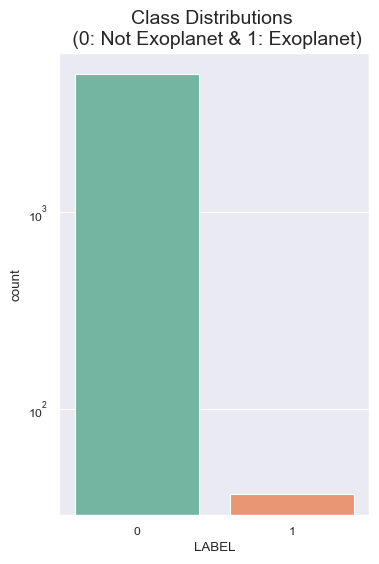

In [31]:
plt.figure(figsize=(4,6))
colors = ["0", "1"]
sns.countplot(x=train_data['LABEL'], palette="Set2")

plt.yscale('log')

plt.title('Class Distributions \n (0: Not Exoplanet & 1: Exoplanet)', fontsize=14)

In [32]:
Counter(test_data['LABEL'])

Counter({0: 565, 1: 5})

## Distribution of the Data

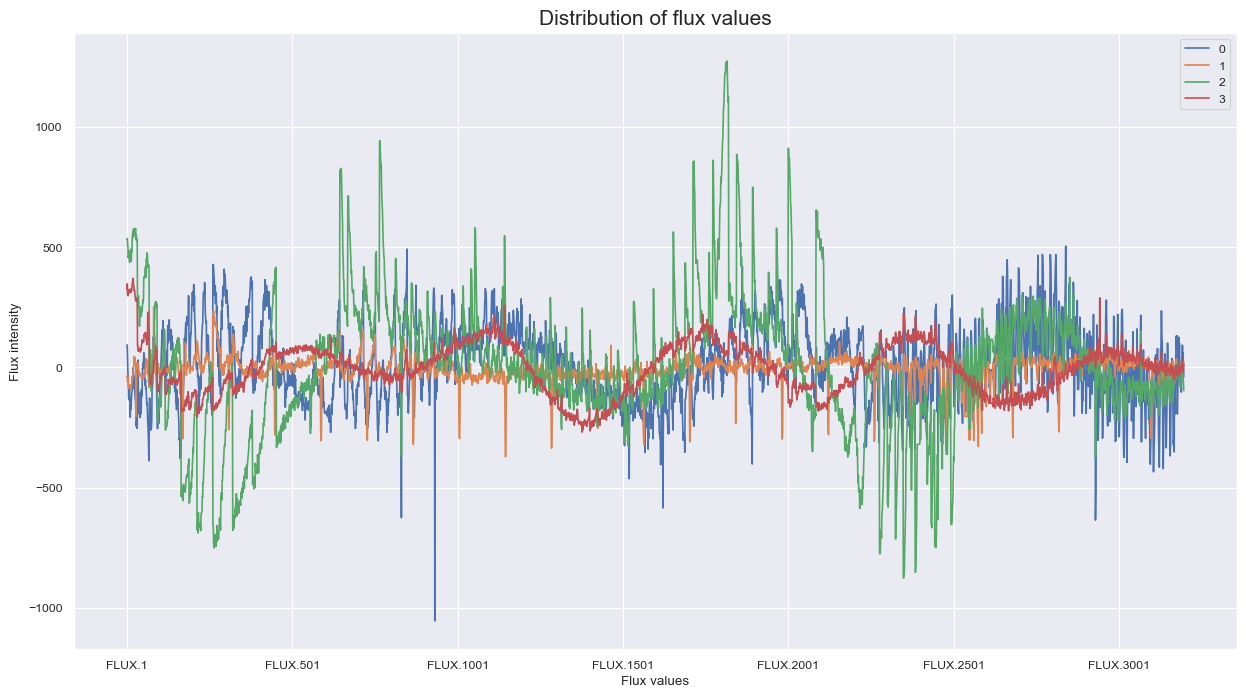

In [33]:
fig, ax = plt.subplots(figsize=(15, 8))

plot_df = train_data[0:4].drop('LABEL', axis=1)
plot_df.T.plot(ax=ax)

plt.title('Distribution of flux values', fontsize=15)
plt.xlabel('Flux values')
plt.ylabel('Flux intensity')

plt.show()


In [34]:
train_aver_1 = train_data.loc[train_data['LABEL']==1].mean(axis=0).to_numpy()
train_aver_0 = train_data.loc[train_data['LABEL']==0].mean(axis=0).to_numpy()
test_aver_1 = train_data.loc[train_data['LABEL']==1].mean(axis=0).to_numpy()
test_aver_0 = train_data.loc[train_data['LABEL']==0].mean(axis=0).to_numpy()

In [35]:
arr = np.stack([train_aver_1, train_aver_0, test_aver_1, test_aver_0], axis=0)

columns = train_data.loc[train_data['LABEL']==0].mean(axis=0).index

average = pd.DataFrame(arr, columns=columns)
average

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1.0,4096.964355,3524.307861,2771.165527,2223.029297,1836.404297,1283.214478,1129.359741,486.174896,46.912704,...,-256.074615,-649.084656,-925.024170,-851.479919,-614.981628,-311.163513,69.504318,335.871033,721.738403,1011.166504
1,0.0,115.546860,103.698219,127.909233,141.007751,143.836853,138.639603,109.419556,111.775124,123.420334,...,352.987762,504.034790,682.815552,758.589783,703.325928,662.384277,-498.919342,-551.045227,-448.752563,-310.146912
2,1.0,4096.964355,3524.307861,2771.165527,2223.029297,1836.404297,1283.214478,1129.359741,486.174896,46.912704,...,-256.074615,-649.084656,-925.024170,-851.479919,-614.981628,-311.163513,69.504318,335.871033,721.738403,1011.166504
3,0.0,115.546860,103.698219,127.909233,141.007751,143.836853,138.639603,109.419556,111.775124,123.420334,...,352.987762,504.034790,682.815552,758.589783,703.325928,662.384277,-498.919342,-551.045227,-448.752563,-310.146912


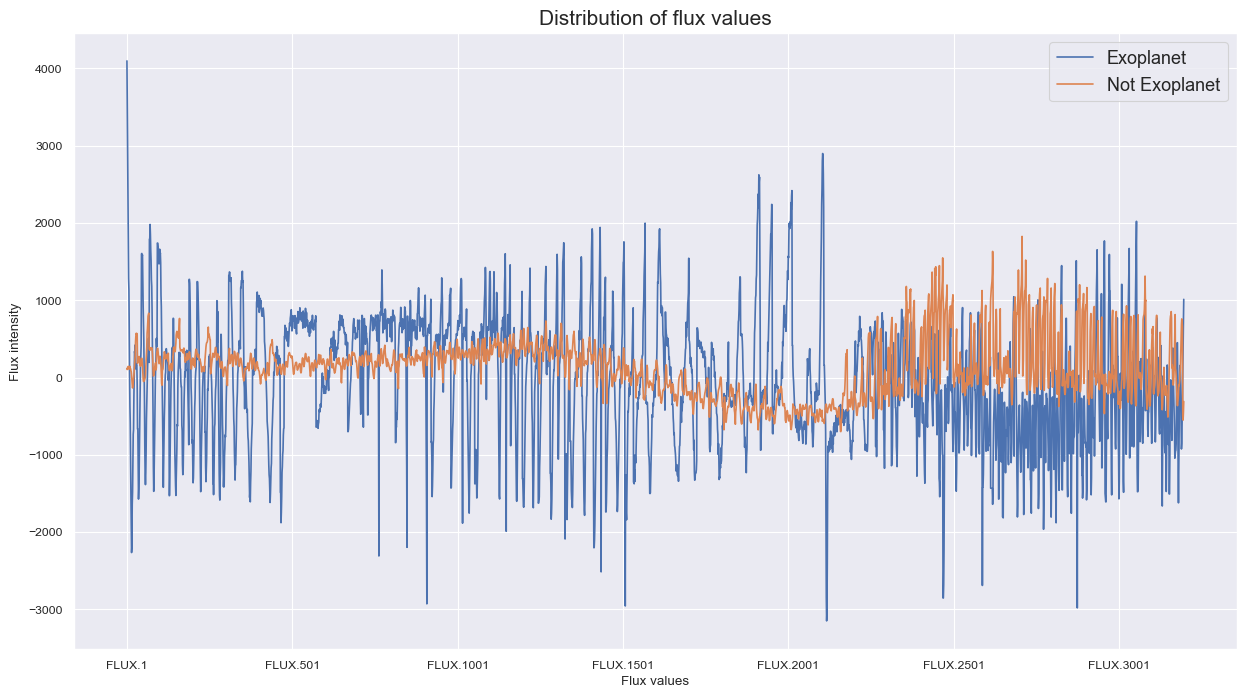

In [36]:
fig, ax = plt.subplots(figsize=(15, 8))

plot_df_1 = average.loc[average['LABEL']==1].drop('LABEL', axis=1).mean(axis=0)
plot_df_0 = average.loc[average['LABEL']==0].drop('LABEL', axis=1).mean(axis=0)

plot_df_1.T.plot(ax=ax, label='Exoplanet')
plot_df_0.T.plot(ax=ax, label='Not Exoplanet')

plt.title('Distribution of flux values', fontsize=15)
plt.xlabel('Flux values')
plt.ylabel('Flux intensity')
plt.legend(fontsize=13)

plt.show()

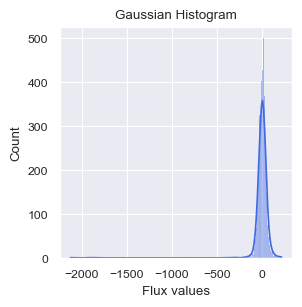

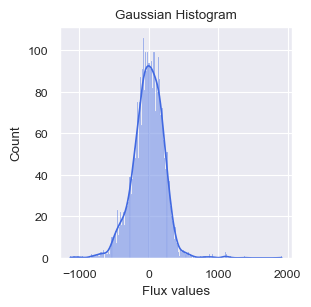

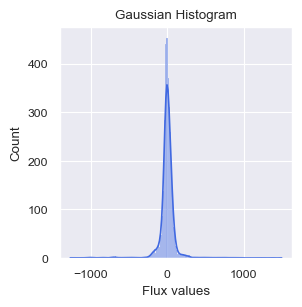

In [37]:
labels_1 = [100, 200, 300]

for i in labels_1:
    plt.figure(figsize=(3,3))
    
    sns.histplot(train_data.iloc[i,:], bins=200, color='royalblue', kde=True)

    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    
    plt.show()

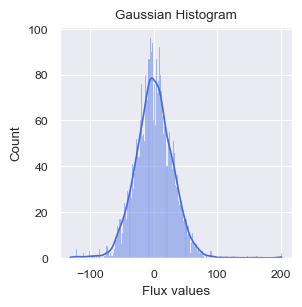

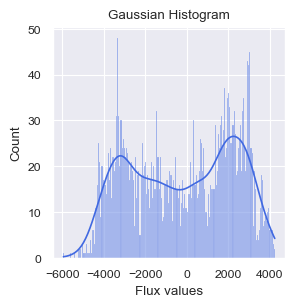

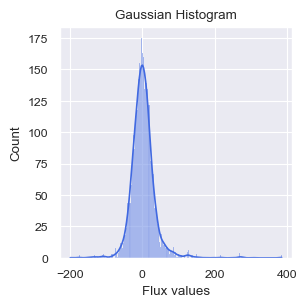

In [38]:
labels_1 = [16, 21, 25]
for i in labels_1:
    plt.figure(figsize=(3,3))
    
    sns.histplot(train_data.iloc[i,:], bins=200, color='royalblue', kde=True)

    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    
    plt.show()

## Splitting & Preparing data

In [137]:
# splitting the data
x_train = train_data.drop(["LABEL"],axis=1)
y_train = train_data["LABEL"]   
x_test = test_data.drop(["LABEL"],axis=1)
y_test = test_data["LABEL"]

In [138]:
# normalizing the data
x_train = normalized = normalize(x_train)
x_test = normalize(x_test)

In [139]:
# Applying of gaussian filter
x_train = filtered = ndimage.filters.gaussian_filter(x_train, sigma=10)
x_test = ndimage.filters.gaussian_filter(x_test, sigma=10)

In [140]:
# Feature scaling
std_scaler = StandardScaler()
x_train = scaled = std_scaler.fit_transform(x_train)
x_test = std_scaler.fit_transform(x_test)

## PCA for Dimensionality Reduction

In [43]:
# these lines from the original notebook were not doing anything
# so I commented it out

'''pca = PCA()

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

total = sum(pca.explained_variance_)
k = 0
current_variance = 0

while current_variance / total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1''';

In [44]:
# choosing optimal dimension
loss = 100

comp = 5  # number of components

while loss > 10:
    pca = PCA(n_components=comp)
    
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)

    loss = (1 - pca.explained_variance_ratio_.sum()) * 100
    print('No. of Components =', comp)
    print('Variance Loss = ', loss)
    comp += 1
    print(' ')

No. of Components = 5
Variance Loss =  60.598552227020264
 
No. of Components = 6
Variance Loss =  56.078916788101196
 
No. of Components = 7
Variance Loss =  51.768410205841064
 
No. of Components = 8
Variance Loss =  48.08896780014038
 
No. of Components = 9
Variance Loss =  44.72188353538513
 
No. of Components = 10
Variance Loss =  41.849613189697266
 
No. of Components = 11
Variance Loss =  39.14946913719177
 
No. of Components = 12
Variance Loss =  36.67214512825012
 
No. of Components = 13
Variance Loss =  34.365665912628174
 
No. of Components = 14
Variance Loss =  32.10781216621399
 
No. of Components = 15
Variance Loss =  30.119633674621582
 
No. of Components = 16
Variance Loss =  28.34615707397461
 
No. of Components = 17
Variance Loss =  26.772230863571167
 
No. of Components = 18
Variance Loss =  25.25760531425476
 
No. of Components = 19
Variance Loss =  23.943817615509033
 
No. of Components = 20
Variance Loss =  22.654694318771362
 
No. of Components = 21
Variance Loss

In [141]:
pca_37 = PCA(n_components=37)

x_train_pca37 = pca_37.fit_transform(x_train)
x_test_pca37 = pca_37.transform(x_test)

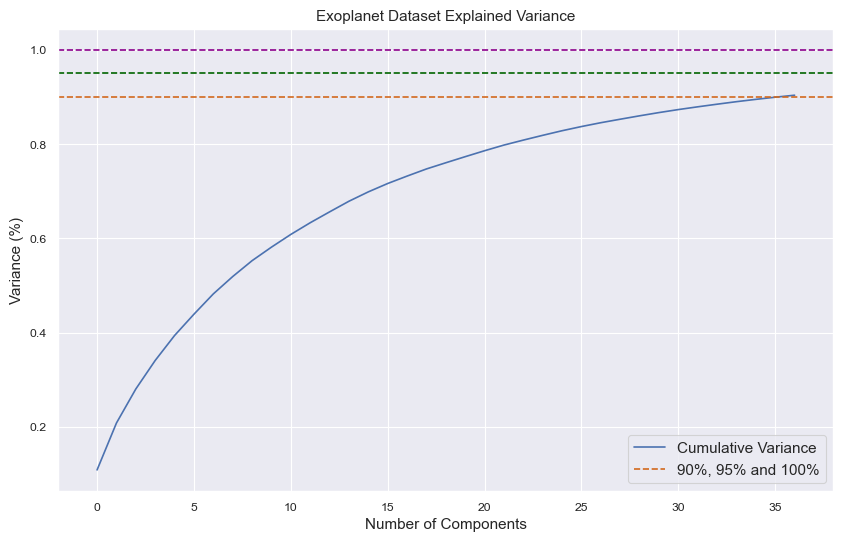

In [46]:
plt.figure()

plt.plot(np.cumsum(pca_37.explained_variance_ratio_), label='Cumulative Variance')

plt.xlim(-2, 38)
plt.hlines([0.90, 0.95, 1.0], -2, 38, linestyles='dashed', 
           colors=['chocolate', 'darkgreen', 'darkmagenta'], 
           label='90%, 95% and 100%')

plt.xlabel('Number of Components', fontsize=11)
plt.ylabel('Variance (%)', fontsize=11)  # for each component
plt.title('Exoplanet Dataset Explained Variance', fontsize=11)

plt.legend(loc='lower right', fontsize=11)

plt.show()

In [47]:
pca37_df = pd.DataFrame.from_records(x_train_pca37)
pca37_df['LABEL'] = y_train
pca37_df

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,LABEL
0,46.931255,18.137709,58.752823,18.286049,24.952984,19.835289,-24.117479,-31.489248,-2.823263,-3.628572,...,2.615654,-2.284920,-8.526737,2.785999,6.259520,-5.378055,-12.650093,-3.298892,-3.588515,1
1,46.963249,18.151140,58.489906,18.449068,24.777416,19.638439,-23.712189,-31.261837,-2.828586,-3.523336,...,2.574075,-2.328514,-8.481082,2.700135,6.276688,-5.302992,-12.590971,-3.296335,-3.592916,1
2,47.028179,18.181854,57.967995,18.770817,24.433207,19.249981,-22.914749,-30.815327,-2.840450,-3.320855,...,2.491185,-2.413697,-8.393696,2.534668,6.309925,-5.155170,-12.471532,-3.290085,-3.602728,1
3,47.122837,18.223604,57.196167,19.244217,23.930073,18.679268,-21.748085,-30.165266,-2.855038,-3.028964,...,2.366612,-2.539106,-8.263318,2.289803,6.358558,-4.939896,-12.292536,-3.277099,-3.613238,1
4,47.244144,18.282372,56.185165,19.858807,23.286356,17.942423,-20.244852,-29.330120,-2.872752,-2.664769,...,2.198603,-2.700095,-8.094381,1.976123,6.422149,-4.663115,-12.053754,-3.255022,-3.620270,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,-18.568182,-32.553043,5.493440,-10.356516,13.807828,-19.130548,21.911577,-10.947467,6.794705,-5.656473,...,-3.588531,-14.416180,5.954375,4.945901,8.035534,-4.697734,5.754956,-6.010650,-4.531603,0
5083,-18.806160,-33.176876,5.611270,-10.442335,14.335114,-19.253233,21.356386,-10.594994,6.635331,-5.797195,...,-3.629970,-14.545331,6.013399,5.422572,8.436124,-4.786110,5.913015,-5.962558,-4.433252,0
5084,-18.982731,-33.633030,5.700073,-10.502174,14.743388,-19.352915,20.920933,-10.330811,6.515303,-5.904841,...,-3.661016,-14.642513,6.057090,5.792299,8.740841,-4.855354,6.035395,-5.922925,-4.356924,0
5085,-19.099159,-33.932018,5.759164,-10.540351,15.021711,-19.424234,20.620773,-10.154674,6.435613,-5.974746,...,-3.680885,-14.707059,6.085742,6.044298,8.946133,-4.902900,6.118717,-5.894608,-4.304319,0


In [48]:
pca37_df.columns

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,      10,      11,      12,      13,      14,      15,
            16,      17,      18,      19,      20,      21,      22,      23,
            24,      25,      26,      27,      28,      29,      30,      31,
            32,      33,      34,      35,      36, 'LABEL'],
      dtype='object')

<Axes: >

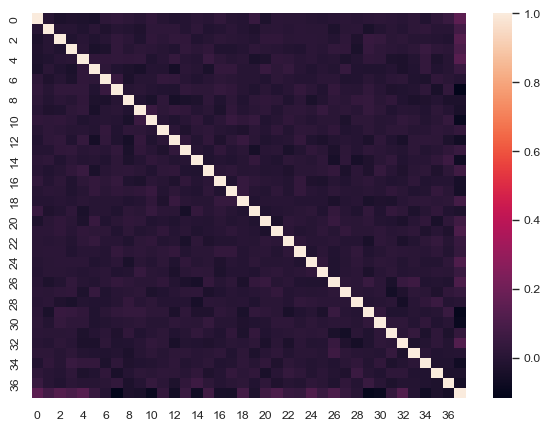

In [49]:
corr_37 = pca37_df.corr(method='spearman')

plt.figure(figsize=(7, 5))
sns.heatmap(corr_37)#, annot=True)

### Distribution of PCA Components

In [50]:
pca37_df_1 = pca37_df.loc[pca37_df['LABEL']==1].mean(axis=0).to_numpy()
pca37_df_0 = pca37_df.loc[pca37_df['LABEL']==0].mean(axis=0).to_numpy()

arr = np.stack([pca37_df_1, pca37_df_0], axis=0)
columns = pca37_df.loc[pca37_df['LABEL']==0].mean(axis=0).index

pca37_df_aver = pd.DataFrame(arr, columns=columns)
pca37_df_aver

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,LABEL
0,56.977745,13.545095,31.367088,17.698730,23.288988,5.946736,-2.449273,-16.974630,-2.778801,-3.691160,...,-0.072959,-4.807391,-4.546324,1.892790,5.883338,-0.354806,-4.729760,-1.046738,-1.826271,1.0
1,-0.417461,-0.099241,-0.229818,-0.129674,-0.170632,-0.043570,0.017945,0.124369,0.020359,0.027044,...,0.000535,0.035223,0.033309,-0.013868,-0.043106,0.002600,0.034654,0.007669,0.013381,0.0


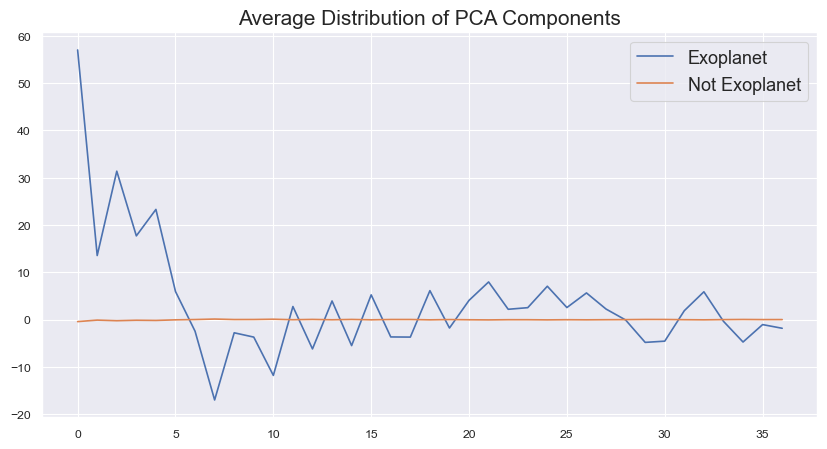

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))

plot_df_1 = pca37_df_aver.loc[pca37_df_aver['LABEL']==1].drop('LABEL', axis=1).mean(axis=0)
plot_df_0 = pca37_df_aver.loc[pca37_df_aver['LABEL']==0].drop('LABEL', axis=1).mean(axis=0)

plot_df_1.T.plot(ax=ax, label='Exoplanet')
plot_df_0.T.plot(ax=ax, label='Not Exoplanet')

plt.title('Average Distribution of PCA Components', fontsize=15)

plt.legend(fontsize=13)

plt.show()

In [52]:
plot_df_1.describe()

count    37.000000
mean      3.596131
std      12.649754
min     -16.974630
25%      -3.657099
50%       2.187565
75%       5.883338
max      56.977745
dtype: float64

In [53]:
plot_df_0.describe()

count    37.000000
mean     -0.026348
std       0.092681
min      -0.417461
25%      -0.043106
50%      -0.016028
75%       0.026795
max       0.124369
dtype: float64

## Re-Sampling

In [54]:
print('Before Re-Sampling:')
print("Number of exoplanet systems: {}".format(sum(y_train==1)))
print("Number of non-exoplanet systems: {} \n".format(sum(y_train==0)))

Before Re-Sampling:
Number of exoplanet systems: 37
Number of non-exoplanet systems: 5050 



In [55]:
under_cc = ClusterCentroids(random_state=42, sampling_strategy={0:2000, 1:37})
x_under, y_under = under_cc.fit_resample(x_train_pca37, y_train)

In [56]:
Counter(y_under)

Counter({0: 2000, 1: 37})

In [136]:
sm = SMOTE(random_state=27)
x_train_res, y_train_res = sm.fit_resample(x_under, y_under.ravel())

In [58]:
print('After Re-Sampling:')
print("Number of exoplanet systems: {}".format(sum(y_train_res==1)))
print("Number of non-exoplanet systems: {} \n".format(sum(y_train_res==0)))

After Re-Sampling:
Number of exoplanet systems: 2000
Number of non-exoplanet systems: 2000 



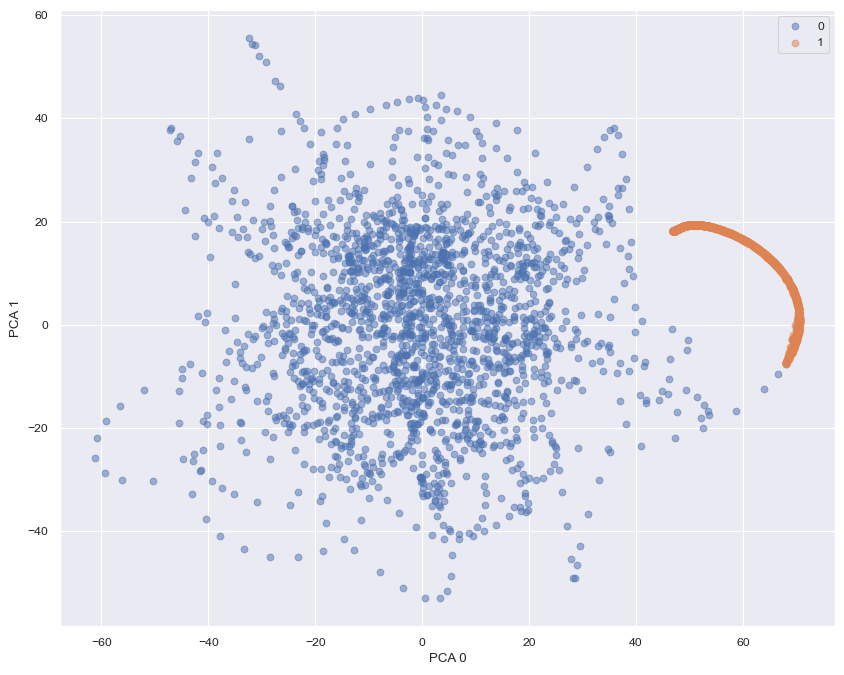

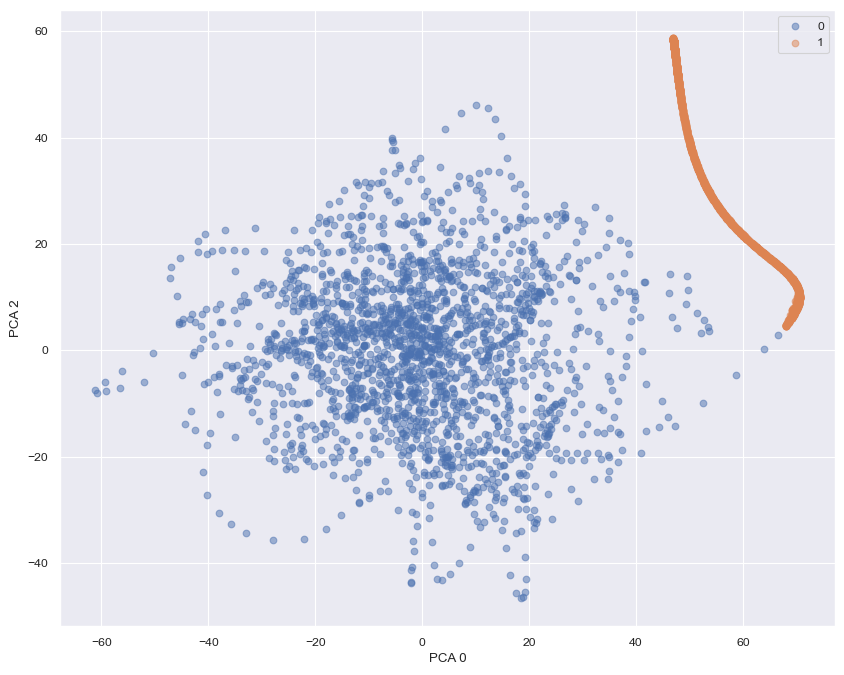

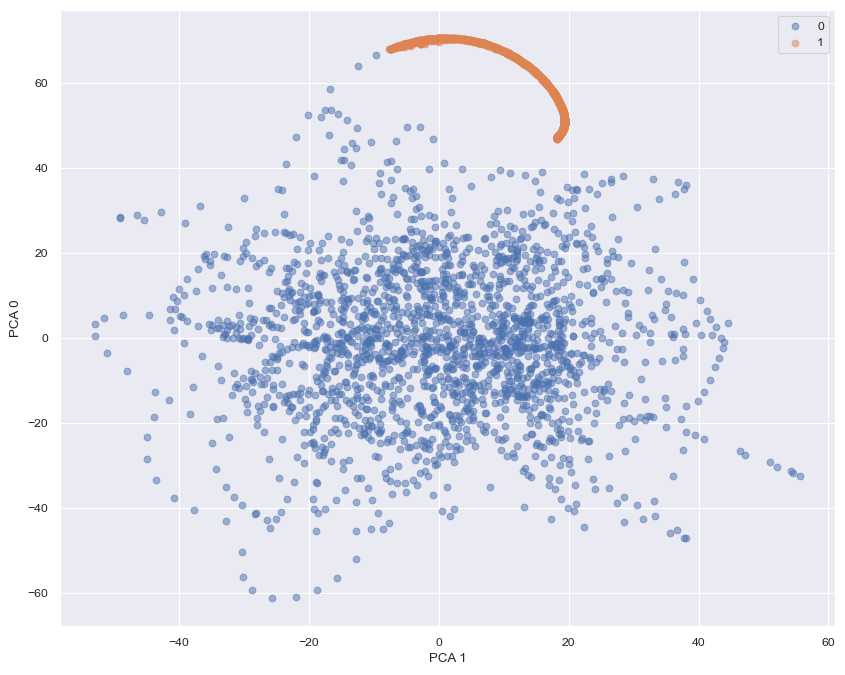

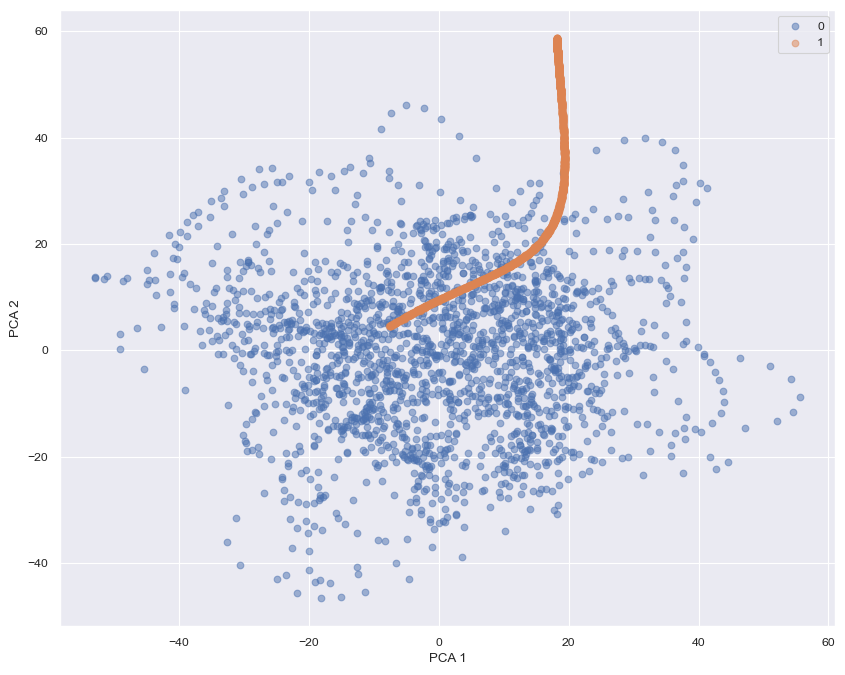

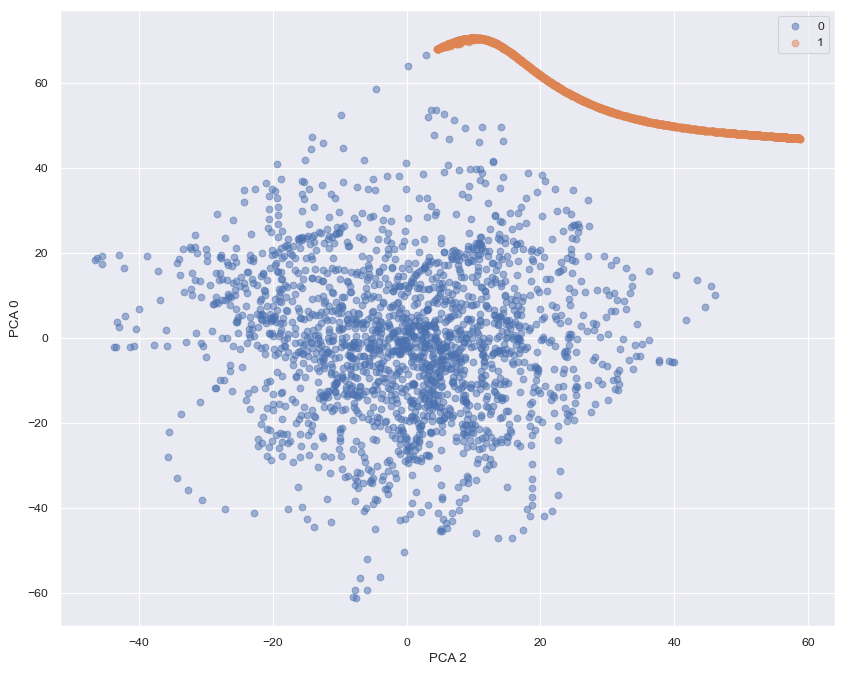

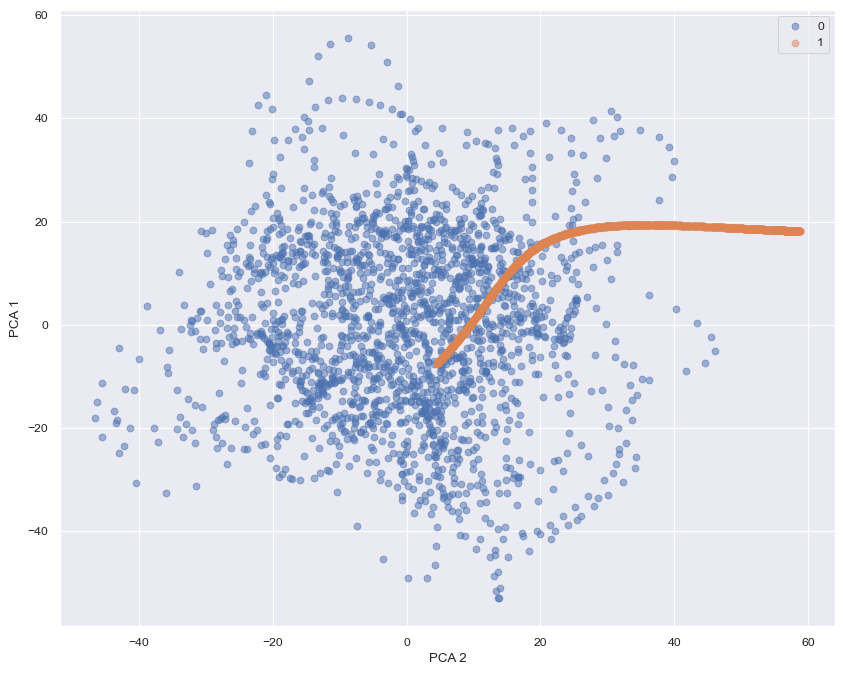

In [59]:
for i in range(3):  # combinations of the first 3 components
    for j in range(3):
        if not j == i:
            # projected coordinates
            fig, ax = plt.subplots(figsize = (10, 8))
            for cat in np.unique(y_train_res):
                mask = (cat == y_train_res)
                ax.scatter(x_train_res[mask][:, i], 
                          x_train_res[mask][:, j], label=cat, 
                          alpha=0.5)

            ax.set_xlabel("PCA " + str(i))
            ax.set_ylabel("PCA " + str(j))
            ax.legend();
            plt.show()

## Neural Network

In [60]:
import pickle5 as pickle

pb = pickle.PickleBuffer(b"foo")
data = pickle.dumps(pb, protocol=5)
assert pickle.loads(data) == b"foo"

### Original NN

In [103]:
def build_classifier():
    classifier = Sequential()

    classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu', input_dim=x_train_res.shape[1]))
    classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return classifier

In [142]:
classifier = KerasClassifier(build_fn=build_classifier, epochs=40, batch_size=32)

# accuracies = cross_val_score(estimator=classifier, X=x_train_res, y=y_train_res, cv=5, n_jobs=-1)

# mean = accuracies.mean()
# variance = accuracies.std()

# print("Accuracy mean: "+ str(mean))
# print("Accuracy variance: "+ str(variance))

history = classifier.fit(x_train_res, y_train_res, verbose=2)

Epoch 1/40
125/125 - 1s - loss: 0.5997 - accuracy: 0.8267 - 756ms/epoch - 6ms/step
Epoch 2/40
125/125 - 0s - loss: 0.1825 - accuracy: 0.9643 - 122ms/epoch - 978us/step
Epoch 3/40
125/125 - 0s - loss: 0.0601 - accuracy: 0.9895 - 116ms/epoch - 929us/step
Epoch 4/40
125/125 - 0s - loss: 0.0288 - accuracy: 0.9960 - 116ms/epoch - 929us/step
Epoch 5/40
125/125 - 0s - loss: 0.0171 - accuracy: 0.9983 - 115ms/epoch - 923us/step
Epoch 6/40
125/125 - 0s - loss: 0.0103 - accuracy: 0.9995 - 119ms/epoch - 949us/step
Epoch 7/40
125/125 - 0s - loss: 0.0066 - accuracy: 0.9998 - 127ms/epoch - 1ms/step
Epoch 8/40
125/125 - 0s - loss: 0.0051 - accuracy: 0.9995 - 118ms/epoch - 941us/step
Epoch 9/40
125/125 - 0s - loss: 0.0041 - accuracy: 0.9995 - 138ms/epoch - 1ms/step
Epoch 10/40
125/125 - 0s - loss: 0.0034 - accuracy: 0.9995 - 188ms/epoch - 2ms/step
Epoch 11/40
125/125 - 0s - loss: 0.0031 - accuracy: 0.9995 - 252ms/epoch - 2ms/step
Epoch 12/40
125/125 - 0s - loss: 0.0026 - accuracy: 0.9995 - 204ms/epoch 

In [143]:
y_pred_mom = classifier.predict(x_test_pca37)
score = accuracy_score(y_test, y_pred_mom)
print('Accuracy = ', score)

18/18 [==============================] - 0s 969us/step
Accuracy =  0.9403508771929825


18/18 [==============================] - 0s 1ms/step


Text(135.41666666666669, 0.5, 'True Label')

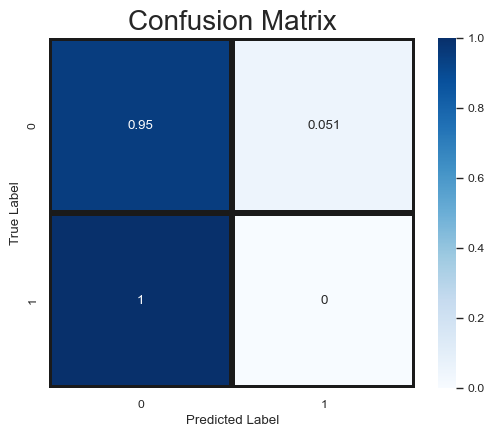

In [144]:
plt.figure(figsize=(13, 10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test, classifier.predict(x_test_pca37), normalize='true'), 
            annot=True, cmap="Blues", linecolor="k", linewidths=3)
plt.title("Confusion Matrix", fontsize=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

### Re-Normalizing the data

### Optimizers

#### Momentum Optimization

In [107]:
def build_classifier_momentum():
    classifier = Sequential()

    classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu', input_dim=x_train_res.shape[1]))
    classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

    classifier.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
    
    return classifier

In [108]:
classifier_mom = KerasClassifier(build_fn=build_classifier_momentum, epochs=40, batch_size=32)

history_mom = classifier_mom.fit(x_train_res, y_train_res, verbose=2)

Epoch 1/40
125/125 - 1s - loss: 0.6710 - accuracy: 0.6250 - 527ms/epoch - 4ms/step
Epoch 2/40
125/125 - 0s - loss: 0.4036 - accuracy: 0.8108 - 114ms/epoch - 910us/step
Epoch 3/40
125/125 - 0s - loss: 0.3256 - accuracy: 0.8960 - 112ms/epoch - 893us/step
Epoch 4/40
125/125 - 0s - loss: 0.2725 - accuracy: 0.9402 - 111ms/epoch - 885us/step
Epoch 5/40
125/125 - 0s - loss: 0.2312 - accuracy: 0.9628 - 123ms/epoch - 984us/step
Epoch 6/40
125/125 - 0s - loss: 0.1982 - accuracy: 0.9755 - 116ms/epoch - 928us/step
Epoch 7/40
125/125 - 0s - loss: 0.1714 - accuracy: 0.9835 - 117ms/epoch - 939us/step
Epoch 8/40
125/125 - 0s - loss: 0.1491 - accuracy: 0.9908 - 112ms/epoch - 898us/step
Epoch 9/40
125/125 - 0s - loss: 0.1307 - accuracy: 0.9940 - 109ms/epoch - 875us/step
Epoch 10/40
125/125 - 0s - loss: 0.1153 - accuracy: 0.9960 - 105ms/epoch - 843us/step
Epoch 11/40
125/125 - 0s - loss: 0.1022 - accuracy: 0.9967 - 124ms/epoch - 988us/step
Epoch 12/40
125/125 - 0s - loss: 0.0911 - accuracy: 0.9980 - 115m

In [109]:
y_pred_mom = classifier_mom.predict(x_test_pca37)
score = accuracy_score(y_test, y_pred_mom)
print('Accuracy = ', score)

18/18 [==============================] - 0s 897us/step
Accuracy =  0.9719298245614035


Text(135.41666666666669, 0.5, 'True Label')

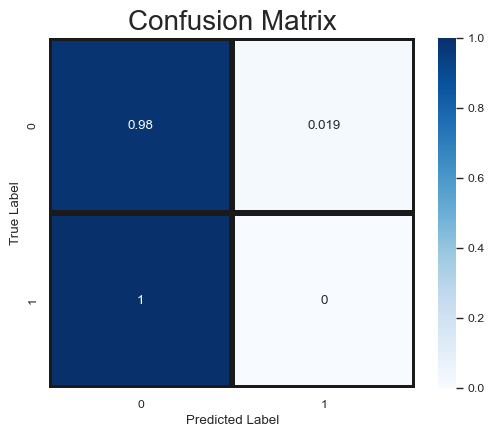

In [110]:
plt.figure(figsize=(13, 10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test, y_pred_mom, normalize='true'), 
            annot=True, cmap="Blues", linecolor="k", linewidths=3)
plt.title("Confusion Matrix", fontsize=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

#### RMSprop

In [112]:
def build_classifier_rms():
    classifier = Sequential()

    classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu', input_dim=x_train_res.shape[1]))
    classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

    classifier.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return classifier

In [113]:
classifier_rms = KerasClassifier(build_fn=build_classifier_rms, epochs=40, batch_size=32)

history_rms = classifier_rms.fit(x_train_res, y_train_res, verbose=2)

Epoch 1/40
125/125 - 1s - loss: 0.5080 - accuracy: 0.8160 - 588ms/epoch - 5ms/step
Epoch 2/40
125/125 - 0s - loss: 0.3308 - accuracy: 0.8885 - 133ms/epoch - 1ms/step
Epoch 3/40
125/125 - 0s - loss: 0.2376 - accuracy: 0.9570 - 134ms/epoch - 1ms/step
Epoch 4/40
125/125 - 0s - loss: 0.1602 - accuracy: 0.9862 - 128ms/epoch - 1ms/step
Epoch 5/40
125/125 - 0s - loss: 0.1114 - accuracy: 0.9952 - 131ms/epoch - 1ms/step
Epoch 6/40
125/125 - 0s - loss: 0.0799 - accuracy: 0.9987 - 128ms/epoch - 1ms/step
Epoch 7/40
125/125 - 0s - loss: 0.0582 - accuracy: 0.9995 - 124ms/epoch - 996us/step
Epoch 8/40
125/125 - 0s - loss: 0.0418 - accuracy: 0.9995 - 119ms/epoch - 953us/step
Epoch 9/40
125/125 - 0s - loss: 0.0293 - accuracy: 0.9995 - 121ms/epoch - 965us/step
Epoch 10/40
125/125 - 0s - loss: 0.0203 - accuracy: 0.9998 - 121ms/epoch - 969us/step
Epoch 11/40
125/125 - 0s - loss: 0.0141 - accuracy: 0.9995 - 212ms/epoch - 2ms/step
Epoch 12/40
125/125 - 0s - loss: 0.0096 - accuracy: 0.9995 - 194ms/epoch - 2m

In [114]:
y_pred_rms = classifier_rms.predict(x_test_pca37)
score = accuracy_score(y_test, y_pred_rms)
print('Accuracy = ', score)

18/18 [==============================] - 0s 2ms/step
Accuracy =  0.9771929824561404


Text(135.41666666666669, 0.5, 'True Label')

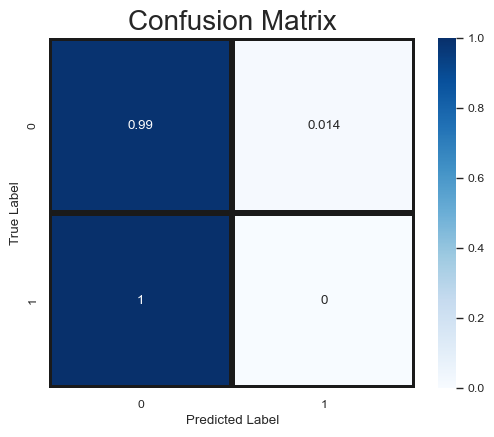

In [115]:
plt.figure(figsize=(13, 10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test, y_pred_rms, normalize='true'), 
            annot=True, cmap="Blues", linecolor="k", linewidths=3)
plt.title("Confusion Matrix", fontsize=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

### Activation Functions

#### Hidden Layers

##### Hyperbolic Tangent

In [120]:
def build_classifier_tanh():
    classifier = Sequential()

    classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu', input_dim=x_train_res.shape[1]))
    classifier.add(Dense(units=4, kernel_initializer='uniform', activation='tanh'))
    classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return classifier

In [121]:
classifier_tanh = KerasClassifier(build_fn=build_classifier_tanh, epochs=40, batch_size=32)

history_tanh = classifier_tanh.fit(x_train_res, y_train_res, verbose=2)

y_pred_tanh = classifier_tanh.predict(x_test_pca37)
score = accuracy_score(y_test, y_pred_tanh)
print('Accuracy = ', score)

Epoch 1/40
125/125 - 1s - loss: 0.6158 - accuracy: 0.8913 - 769ms/epoch - 6ms/step
Epoch 2/40
125/125 - 0s - loss: 0.3967 - accuracy: 0.9735 - 115ms/epoch - 921us/step
Epoch 3/40
125/125 - 0s - loss: 0.2498 - accuracy: 0.9958 - 114ms/epoch - 911us/step
Epoch 4/40
125/125 - 0s - loss: 0.1665 - accuracy: 0.9995 - 115ms/epoch - 919us/step
Epoch 5/40
125/125 - 0s - loss: 0.1196 - accuracy: 0.9995 - 115ms/epoch - 920us/step
Epoch 6/40
125/125 - 0s - loss: 0.0907 - accuracy: 0.9995 - 122ms/epoch - 975us/step
Epoch 7/40
125/125 - 0s - loss: 0.0713 - accuracy: 0.9998 - 198ms/epoch - 2ms/step
Epoch 8/40
125/125 - 0s - loss: 0.0584 - accuracy: 0.9995 - 122ms/epoch - 977us/step
Epoch 9/40
125/125 - 0s - loss: 0.0485 - accuracy: 0.9998 - 118ms/epoch - 948us/step
Epoch 10/40
125/125 - 0s - loss: 0.0409 - accuracy: 0.9998 - 120ms/epoch - 958us/step
Epoch 11/40
125/125 - 0s - loss: 0.0350 - accuracy: 0.9998 - 122ms/epoch - 972us/step
Epoch 12/40
125/125 - 0s - loss: 0.0302 - accuracy: 0.9998 - 122ms/

Text(135.41666666666669, 0.5, 'True Label')

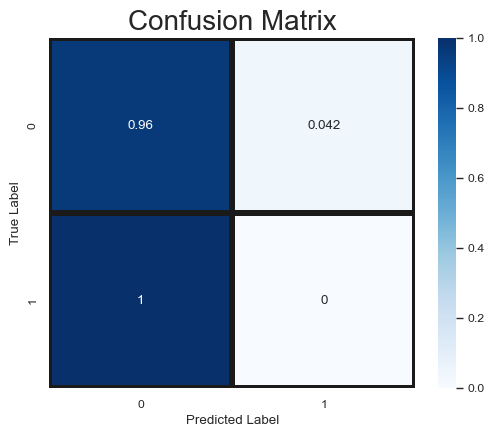

In [122]:
plt.figure(figsize=(13, 10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test, y_pred_tanh, normalize='true'), 
            annot=True, cmap="Blues", linecolor="k", linewidths=3)
plt.title("Confusion Matrix", fontsize=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

##### Sigmoid

In [124]:
def build_classifier_sig():
    classifier = Sequential()

    classifier.add(Dense(units=4, kernel_initializer='uniform', activation='sigmoid', input_dim=x_train_res.shape[1]))
    classifier.add(Dense(units=4, kernel_initializer='uniform', activation='sigmoid'))
    classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return classifier

In [125]:
classifier_sig = KerasClassifier(build_fn=build_classifier_sig, epochs=40, batch_size=32)

history_sig = classifier_sig.fit(x_train_res, y_train_res, verbose=2)

y_pred_sig = classifier_sig.predict(x_test_pca37)
score = accuracy_score(y_test, y_pred_sig)
print('Accuracy = ', score)

Epoch 1/40
125/125 - 1s - loss: 0.6923 - accuracy: 0.5652 - 825ms/epoch - 7ms/step
Epoch 2/40
125/125 - 0s - loss: 0.6843 - accuracy: 0.7713 - 137ms/epoch - 1ms/step
Epoch 3/40
125/125 - 0s - loss: 0.6536 - accuracy: 0.9653 - 136ms/epoch - 1ms/step
Epoch 4/40
125/125 - 0s - loss: 0.5936 - accuracy: 0.9665 - 143ms/epoch - 1ms/step
Epoch 5/40
125/125 - 0s - loss: 0.5130 - accuracy: 0.9770 - 136ms/epoch - 1ms/step
Epoch 6/40
125/125 - 0s - loss: 0.4217 - accuracy: 0.9915 - 130ms/epoch - 1ms/step
Epoch 7/40
125/125 - 0s - loss: 0.3366 - accuracy: 0.9973 - 136ms/epoch - 1ms/step
Epoch 8/40
125/125 - 0s - loss: 0.2680 - accuracy: 0.9977 - 136ms/epoch - 1ms/step
Epoch 9/40
125/125 - 0s - loss: 0.2178 - accuracy: 0.9985 - 131ms/epoch - 1ms/step
Epoch 10/40
125/125 - 0s - loss: 0.1789 - accuracy: 0.9992 - 131ms/epoch - 1ms/step
Epoch 11/40
125/125 - 0s - loss: 0.1497 - accuracy: 0.9992 - 135ms/epoch - 1ms/step
Epoch 12/40
125/125 - 0s - loss: 0.1267 - accuracy: 0.9990 - 129ms/epoch - 1ms/step
E

Text(135.41666666666669, 0.5, 'True Label')

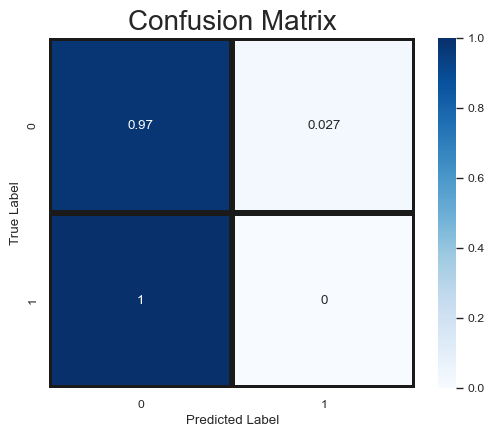

In [126]:
plt.figure(figsize=(13, 10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test, y_pred_sig, normalize='true'), 
            annot=True, cmap="Blues", linecolor="k", linewidths=3)
plt.title("Confusion Matrix", fontsize=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

#### Output Layer

##### Linear

In [145]:
def build_classifier_lin():
    classifier = Sequential()

    classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu', input_dim=x_train_res.shape[1]))
    classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return classifier

In [146]:
classifier_lin = KerasClassifier(build_fn=build_classifier_lin, epochs=40, batch_size=32)

history_lin = classifier_lin.fit(x_train_res, y_train_res, verbose=2)

y_pred_lin = classifier_lin.predict(x_test_pca37)
score = accuracy_score(y_test, y_pred_lin)
print('Accuracy = ', score)

Epoch 1/40
125/125 - 1s - loss: 7.7125 - accuracy: 0.5000 - 839ms/epoch - 7ms/step
Epoch 2/40
125/125 - 0s - loss: 7.7125 - accuracy: 0.5000 - 139ms/epoch - 1ms/step
Epoch 3/40
125/125 - 0s - loss: 7.7125 - accuracy: 0.5000 - 117ms/epoch - 933us/step
Epoch 4/40
125/125 - 0s - loss: 7.7125 - accuracy: 0.5000 - 129ms/epoch - 1ms/step
Epoch 5/40
125/125 - 0s - loss: 7.7125 - accuracy: 0.5000 - 126ms/epoch - 1ms/step
Epoch 6/40
125/125 - 0s - loss: 7.7125 - accuracy: 0.5000 - 125ms/epoch - 997us/step
Epoch 7/40
125/125 - 0s - loss: 7.7125 - accuracy: 0.5000 - 123ms/epoch - 982us/step
Epoch 8/40
125/125 - 0s - loss: 7.7125 - accuracy: 0.5000 - 119ms/epoch - 954us/step
Epoch 9/40
125/125 - 0s - loss: 7.7125 - accuracy: 0.5000 - 128ms/epoch - 1ms/step
Epoch 10/40
125/125 - 0s - loss: 7.7125 - accuracy: 0.5000 - 132ms/epoch - 1ms/step
Epoch 11/40
125/125 - 0s - loss: 7.7125 - accuracy: 0.5000 - 127ms/epoch - 1ms/step
Epoch 12/40
125/125 - 0s - loss: 7.7125 - accuracy: 0.5000 - 137ms/epoch - 1m

Text(135.41666666666669, 0.5, 'True Label')

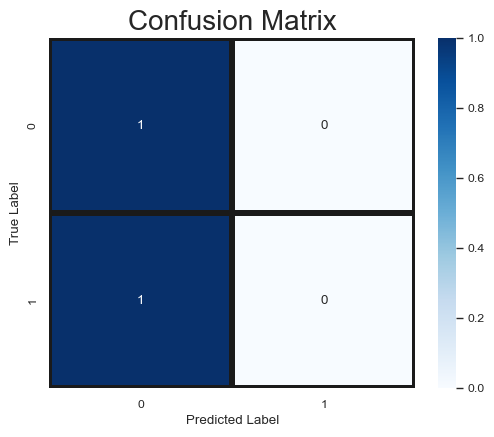

In [147]:
plt.figure(figsize=(13, 10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test, y_pred_lin, normalize='true'), 
            annot=True, cmap="Blues", linecolor="k", linewidths=3)
plt.title("Confusion Matrix", fontsize=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

##### Soft-Max

In [173]:
def build_classifier_smax():
    classifier = Sequential()

    classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu', input_dim=x_train_res.shape[1]))
    classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dense(units=1, kernel_initializer='uniform', activation='softmax'))

    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return classifier

In [174]:
classifier_smax = KerasClassifier(build_fn=build_classifier_smax, epochs=40, batch_size=32)

history_smax = classifier_smax.fit(x_train_res, y_train_res, verbose=2)

y_pred_smax = classifier_smax.predict(x_test_pca37)
score = accuracy_score(y_test, y_pred_smax)
print('Accuracy = ', score)

Epoch 1/40
125/125 - 1s - loss: 0.5922 - accuracy: 0.5000 - 741ms/epoch - 6ms/step
Epoch 2/40
125/125 - 0s - loss: 0.1255 - accuracy: 0.5000 - 133ms/epoch - 1ms/step
Epoch 3/40
125/125 - 0s - loss: 0.0183 - accuracy: 0.5000 - 151ms/epoch - 1ms/step
Epoch 4/40
125/125 - 0s - loss: 0.0076 - accuracy: 0.5000 - 134ms/epoch - 1ms/step
Epoch 5/40
125/125 - 0s - loss: 0.0045 - accuracy: 0.5000 - 127ms/epoch - 1ms/step
Epoch 6/40
125/125 - 0s - loss: 0.0031 - accuracy: 0.5000 - 183ms/epoch - 1ms/step
Epoch 7/40
125/125 - 0s - loss: 0.0023 - accuracy: 0.5000 - 153ms/epoch - 1ms/step
Epoch 8/40
125/125 - 0s - loss: 0.0018 - accuracy: 0.5000 - 130ms/epoch - 1ms/step
Epoch 9/40
125/125 - 0s - loss: 0.0015 - accuracy: 0.5000 - 129ms/epoch - 1ms/step
Epoch 10/40
125/125 - 0s - loss: 0.0013 - accuracy: 0.5000 - 117ms/epoch - 936us/step
Epoch 11/40
125/125 - 0s - loss: 0.0011 - accuracy: 0.5000 - 126ms/epoch - 1ms/step
Epoch 12/40
125/125 - 0s - loss: 9.6043e-04 - accuracy: 0.5000 - 120ms/epoch - 959u

Text(135.41666666666669, 0.5, 'True Label')

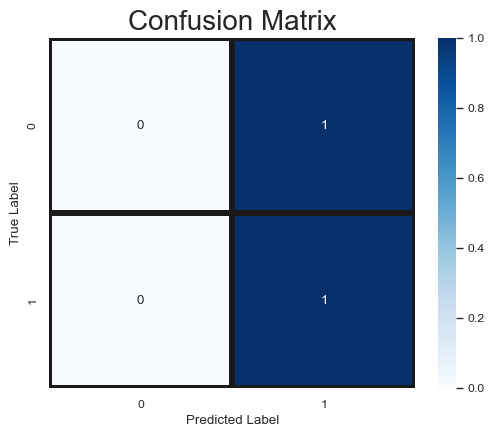

In [175]:
plt.figure(figsize=(13, 10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test, y_pred_smax, normalize='true'), 
            annot=True, cmap="Blues", linecolor="k", linewidths=3)
plt.title("Confusion Matrix", fontsize=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

### Deeper NN

In [170]:
x_train_res = normalized = normalize(x_train_res)
x_test_pca37 = normalize(x_test_pca37)

x_train_res = filtered = ndimage.filters.gaussian_filter(x_train_res, sigma=10)
x_test_pca37 = ndimage.filters.gaussian_filter(x_test_pca37, sigma=10)

x_train_res = scaled = std_scaler.fit_transform(x_train_res)
x_test_pca37 = std_scaler.fit_transform(x_test_pca37)

In [180]:
def build_classifier_deep():
    classifier = Sequential()

    classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu', input_dim=x_train_res.shape[1]))
    classifier.add(BatchNormalization(axis=1))
    classifier.add(Dense(units=16, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(units=32, kernel_initializer='uniform', activation='relu'))
    classifier.add(BatchNormalization(axis=1))
    classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return classifier

In [181]:
classifier_deep = KerasClassifier(build_fn=build_classifier_deep, epochs=100, batch_size=16)

history_deep = classifier_smax.fit(x_train_res, y_train_res, verbose=2)

y_pred_deep = classifier_smax.predict(x_test_pca37)
score = accuracy_score(y_test, y_pred_deep)
print('Accuracy = ', score)

Epoch 1/40
125/125 - 1s - loss: 0.6353 - accuracy: 0.5000 - 856ms/epoch - 7ms/step
Epoch 2/40
125/125 - 0s - loss: 0.3481 - accuracy: 0.5000 - 118ms/epoch - 946us/step
Epoch 3/40
125/125 - 0s - loss: 0.2456 - accuracy: 0.5000 - 116ms/epoch - 926us/step
Epoch 4/40
125/125 - 0s - loss: 0.1868 - accuracy: 0.5000 - 121ms/epoch - 972us/step
Epoch 5/40
125/125 - 0s - loss: 0.1402 - accuracy: 0.5000 - 117ms/epoch - 936us/step
Epoch 6/40
125/125 - 0s - loss: 0.1045 - accuracy: 0.5000 - 122ms/epoch - 973us/step
Epoch 7/40
125/125 - 0s - loss: 0.0783 - accuracy: 0.5000 - 117ms/epoch - 938us/step
Epoch 8/40
125/125 - 0s - loss: 0.0593 - accuracy: 0.5000 - 150ms/epoch - 1ms/step
Epoch 9/40
125/125 - 0s - loss: 0.0456 - accuracy: 0.5000 - 217ms/epoch - 2ms/step
Epoch 10/40
125/125 - 0s - loss: 0.0356 - accuracy: 0.5000 - 199ms/epoch - 2ms/step
Epoch 11/40
125/125 - 0s - loss: 0.0283 - accuracy: 0.5000 - 199ms/epoch - 2ms/step
Epoch 12/40
125/125 - 0s - loss: 0.0228 - accuracy: 0.5000 - 214ms/epoch 

Text(135.41666666666669, 0.5, 'True Label')

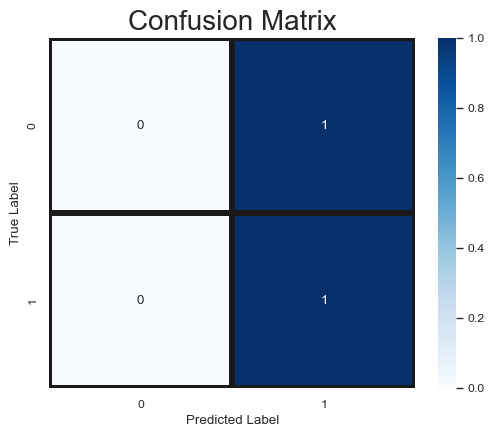

In [182]:
plt.figure(figsize=(13, 10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test, y_pred_deep, normalize='true'), 
            annot=True, cmap="Blues", linecolor="k", linewidths=3)
plt.title("Confusion Matrix", fontsize=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')